## ASSESSMENT
1. Build a prediction model that predicts the average WOZ value
2. Build a REST web service that includes all features and returns a prediction of the WOZ. See
the examples of how the request and response should look:
Request
GET
/api/get_woz_value?parameter1=value&parameter2=value&....&parameterN=value
Response
{
“woz_value” : 500000
}
3. Package your model REST web service into a ready to be deployed solution. Finally, the
code should follow clean coding best practices. The solution should come bundled with all
necessary dependencies so that nothing besides a computer and an internet connection are
needed to run the application and reproduce the results.
4. The Municipality would like to make this service available for other governments as well as
real estate agencies so that it can be used as a basis indicator for house valuation. How
would you approach deploying this web service to a cloud environment of your choice
(AWS, GCP or Azure), taking into account the following requirements:
-   The web service should have high availability and scalability to
accommodate peaks in usage. Only authenticated clients should have access
to the service.
-   Historical & new data of daily frequency, reside/arrive as CSV files at the
object storage of the cloud environment of your choice (AWS S3/ GCP Cloud
Storage/ Azure Blob Storage). An ETL mechanism is necessary to transform
the raw form of new batches to be used for the model.
-   Cost should be kept as low as possible without impact on the requirements.

#### Note:
We expect you to visualize and explain your architecture, not actually implement it.
#### Guidelines
- You are allowed to use any technology you are comfortable in
- Your code/solution should be easily runnable by other machine learning engineers.
- Include visualizations/statistics that you found during the development of your
model
- Make sure the model is useful for the end user (Municipality in this case)
- Reason about the quality of your predictions
- Include a visual of your high level architecture of the cloud deployed web service to
make it easier to understand your approach and prepare for a discussion on your
design choices.
GOOD LUCK

#### SOLUTION

'''
This purpose of this notebook is to experiment with different regressor models and general data exploration.
'''

In [43]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump


In [83]:
# Read the data
header_columns=["area","single","married, no kids","not married, no kids","married, with kids","not married, with kids","single parent","other","total"]
df = pd.read_excel('data/2021_family_composition_amsterdam.xlsx', engine='openpyxl', skiprows=2, usecols="A:I")
prices = pd.read_excel('data/woz_prices_2021_amsterdam.xlsx', engine='openpyxl', skiprows=2, usecols="A:B")

In [84]:
# Remove rows with all null values and drop redundant columns
prices.dropna(how="all", inplace=True)
df.dropna(how="all", inplace=True)
df = df.loc[df["area"] != "ASD Amsterdam"]
prices = prices.loc[prices["area"] != "ASD Amsterdam"]
df.drop('total', axis=1, inplace=True)

In [89]:
# Merge the dataframes on the 'area' column
df = df.merge(prices, on='area', how='inner')
col = ['single', 'married, no kids', 'not married, no kids', 'married, with kids', 'not married, with kids', 'single parent', 'other', 'average woz value']
df[col] = df[col].apply(pd.to_numeric, errors='coerce')


In [90]:
# Print column having more than 50% missing values 
missing = 100 * (df.isnull().sum()/df.shape[0])
missing

area                      0.000000
single                    1.196172
married, no kids          4.066986
not married, no kids      3.349282
married, with kids        5.263158
not married, with kids    5.980861
single parent             5.023923
other                     9.569378
average woz value         7.655502
dtype: float64

In [91]:
#Since the number of null values are below 10%, lets impute it with mean
df.fillna(round(df.mean(),0), inplace=True)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   area                    418 non-null    object 
 1   single                  418 non-null    float64
 2   married, no kids        418 non-null    float64
 3   not married, no kids    418 non-null    float64
 4   married, with kids      418 non-null    float64
 5   not married, with kids  418 non-null    float64
 6   single parent           418 non-null    float64
 7   other                   418 non-null    float64
 8   average woz value       418 non-null    float64
dtypes: float64(8), object(1)
memory usage: 32.7+ KB


In [93]:
df

,area,single,"married, no kids","not married, no kids","married, with kids","not married, with kids",single parent,other,average woz value
0,A00a Kop Zeedijk,543.0,37.0,149.0,14.0,12.0,22.0,12.0,432583.0
1,A00b Oude Kerk e.o.,331.0,20.0,104.0,8.0,3.0,20.0,12.0,475037.0
2,A00c Burgwallen Oost,676.0,55.0,231.0,30.0,23.0,43.0,26.0,469793.0
3,A00d Nes e.o.,130.0,16.0,59.0,5.0,8.0,11.0,5.0,605863.0
4,A00e BG-terrein e.o.,348.0,24.0,73.0,19.0,9.0,14.0,6.0,556369.0
...,...,...,...,...,...,...,...,...,...
413,T97a Gein Noordwest,977.0,71.0,142.0,88.0,63.0,300.0,22.0,211475.0
414,T97b Gein Zuidwest,421.0,41.0,70.0,72.0,51.0,186.0,10.0,221090.0
415,T97c Gein Noordoost,380.0,362.0,91.0,325.0,107.0,125.0,14.0,332620.0
416,T97d Gein Zuidoost,718.0,242.0,97.0,220.0,104.0,274.0,17.0,280695.0


### Building a Regressor 

In [48]:
# Split the dataframe into train and test sets
from sklearn.model_selection import train_test_split

X = df[df.drop(['area','average woz value'],axis=1).columns]
y = df['average woz value']
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
# Standardize the training and test sets
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

#Log-transform the target variable as it has high numeric values and slightly skewed  
#y_train_log = np.log(y_train)

# Save the PCA object
dump(scaler, 'lib/scaler.joblib')

['lib/scaler.joblib']

In [75]:
import matplotlib.pyplot as plt
# Apply PCA to the training set to get best number of components
pca = PCA()
pca.fit(X_train_std)
pca_cumulative_var_ratio = pca.explained_variance_ratio_.cumsum()
num_components = sum(pca_cumulative_var_ratio < 0.95) + 1
pca = PCA(n_components=num_components)


In [73]:
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

# Transform the test set using the same PCA model
X_test_pca = pca.transform(X_test)

# Save the PCA object
dump(pca, 'lib/pca.joblib')

['lib/pca.joblib']

In [52]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

#### Checking performance on scaled and PCA data 

In [53]:
# Initialize variables to store the best regressor and its mean R-squared score
best_regressor = None
best_score = 0

for regressor in regressors:
    # Compute the cross-validation score using 5 folds and the R-squared metric
    scores = cross_val_score(regressor, X_train_pca, y_train, cv=5, scoring='r2')
    
    # Compute the mean R-squared score
    mean_score = scores.mean()
    
    # Print the cross-validation scores and their mean and standard deviation)
    print(regressor.__class__.__name__)
    print("Cross-Validation Scores:", scores)
    print("Mean R-squared:", scores.mean())
    print("Standard Deviation:", scores.std())
    print("\n")
    
    # Update the best regressor and its mean R-squared score if the current model performs better
    if mean_score > best_score:
        best_regressor = regressor
        best_score = mean_score
        
# Print the best performing regressor and its mean R-squared score
print("Best performing regressor:", best_regressor.__class__.__name__)
print("Mean R-squared:", best_score)

LinearRegression
Cross-Validation Scores: [0.24745409 0.10159848 0.20271533 0.16392079 0.23693314]
Mean R-squared: 0.1905243683628914
Standard Deviation: 0.05321456797002546


Ridge
Cross-Validation Scores: [0.24745412 0.10159848 0.20271534 0.16392077 0.23693333]
Mean R-squared: 0.19052440774366805
Standard Deviation: 0.053214610734211465


Lasso
Cross-Validation Scores: [0.2474541  0.10159848 0.20271533 0.16392079 0.23693315]
Mean R-squared: 0.1905243703800976
Standard Deviation: 0.05321457138491528


RandomForestRegressor
Cross-Validation Scores: [0.33177226 0.47804087 0.25015283 0.35595564 0.49186742]
Mean R-squared: 0.3815578054056187
Standard Deviation: 0.09151888436970558


DecisionTreeRegressor
Cross-Validation Scores: [-1.01099723  0.24440205 -0.1713168   0.34748215 -0.06259626]
Mean R-squared: -0.1306052183903865
Standard Deviation: 0.4797021420444285


Best performing regressor: RandomForestRegressor
Mean R-squared: 0.3815578054056187


In [67]:
model = best_regressor
param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 5, 10, 20, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 400]})

In [68]:
 
y_pred = grid_search.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

Mean Squared Error: 23041963622.550568


0.4202632034123155

In [69]:


# Assume y_true and y_pred are the true and predicted target values, respectively
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
me = max_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)
print("Explained Variance Score:", evs)
print("Max Error:", me)

Mean Squared Error: 23041963622.550568
Root Mean Squared Error: 151795.79579998442
Mean Absolute Error: 97033.52571428573
R-squared: 0.4202632034123155
Explained Variance Score: 0.4225970825299441
Max Error: 763262.37


Text(0, 0.5, 'y_pred')

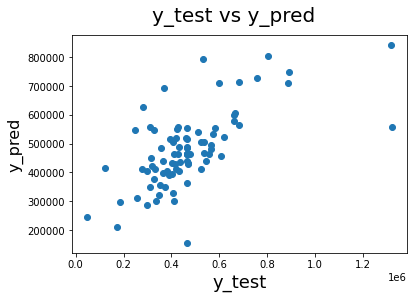

In [71]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16) 

In [1]:
# Saving the best model 
#import joblib
# Save the best estimator as a pickled file
#joblib.dump(grid_search, 'lib/model.pkl')